# Data generation

## Resources

-  [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset
-  [OpenSlide](https://openslide.org/),
- [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom)
-  [paper](https://arxiv.org/abs/1703.02442) 


In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,053 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# Download an example slide and tumor mask

# Important note: the remainder are in a Google Drive folder, linked above.
# Data hosted in GGS (Google Cloud Storage)

# my GCS
slide_path = 'tumor_110.tif'
tumor_mask_path = 'tumor_110_mask.tif'

slide_url = 'https://storage.googleapis.com/adl-project/slides/%s' % slide_path
mask_url = 'https://storage.googleapis.com/adl-project/slides/%s' % tumor_mask_path

# slide id
sid = 110



# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416M  100 1416M    0     0   122M      0  0:00:11  0:00:11 --:--:--  113M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.3M  100 31.3M    0     0  57.9M      0 --:--:-- --:--:-- --:--:-- 57.8M


### Mount Google Drive

In [0]:
# Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! ls /content/gdrive/My\ Drive/slides | head -5

ls: cannot access '/content/gdrive/My Drive/slides': No such file or directory


In [0]:
data_path = '/content/gdrive/My Drive/slides'
#slide_path = data_path + '/tumor_001.tif'

### Open slide

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels" % len(slide.level_dimensions))
#for i in range(len(slide.level_dimensions)):
for i in range(len(tumor_mask.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_110.tif with width: 94208, height: 71680
Read tumor mask from tumor_110_mask.tif
Slide includes 9 levels
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


### Note
- Produce prediction on level 7 using level 4, level 6 and level 7. 
- Levels below level 4 are not used because the resolution is too high and the data is too large for this project.

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

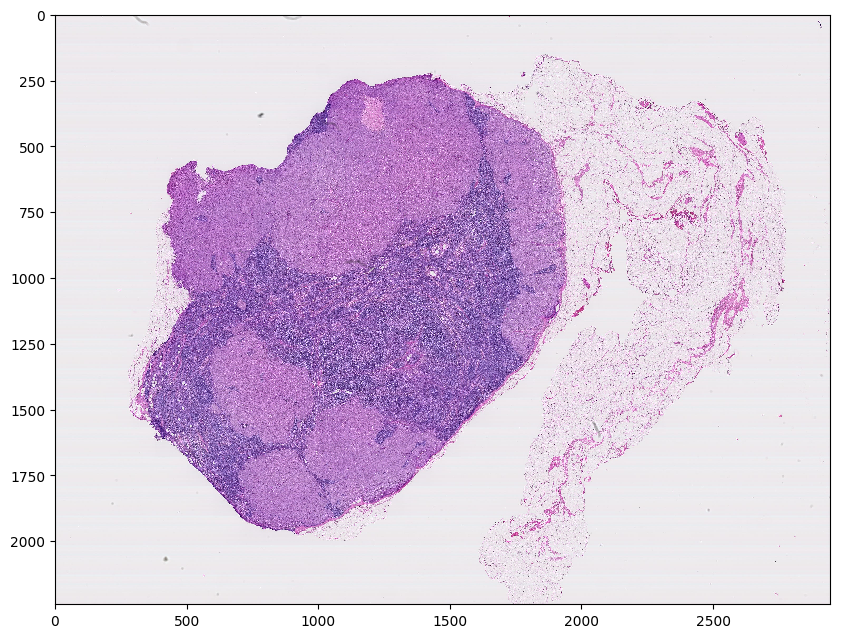

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])


plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

## Crop slide

2691
2093
<type 'int'>
73


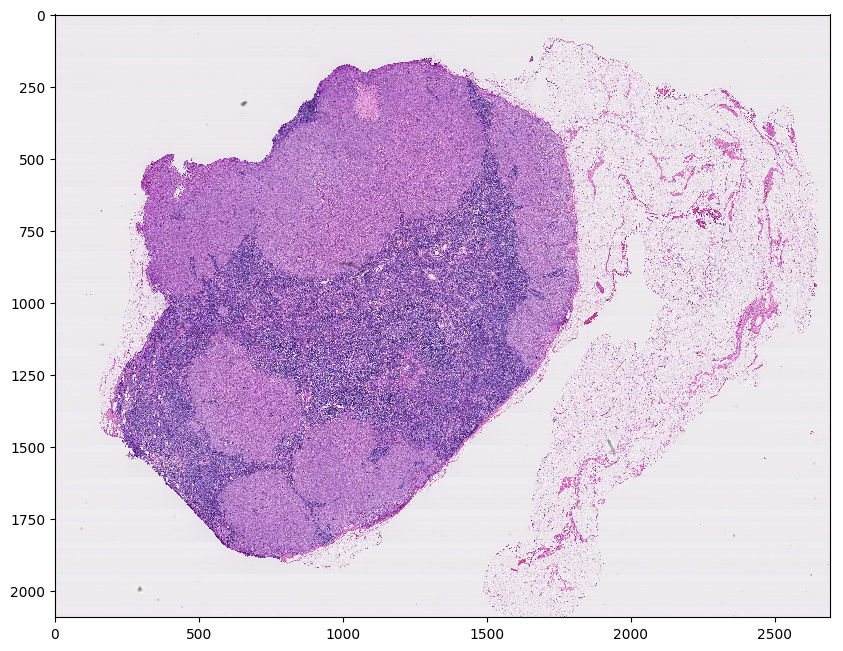

In [0]:
size = 299
factor = int(slide.level_downsamples[5])

w_num = slide.level_dimensions[5][0]//size # w_num
h_num = slide.level_dimensions[5][1]//size # h_num

new_w = size*w_num
new_h = size*h_num

print(new_w)
print(new_h)
assert new_w % 299 == 0
assert new_h % 299 == 0

tlx = (slide.level_dimensions[5][0] - size*w_num)//2
tly = (slide.level_dimensions[5][1] - size*h_num)//2
print(type(tlx))
print(tly)

slide_crop = read_slide(slide, 
                         x=tlx*factor, 
                         y=tly*factor, 
                         level=5, 
                         width=new_w, 
                         height=new_h)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_crop)

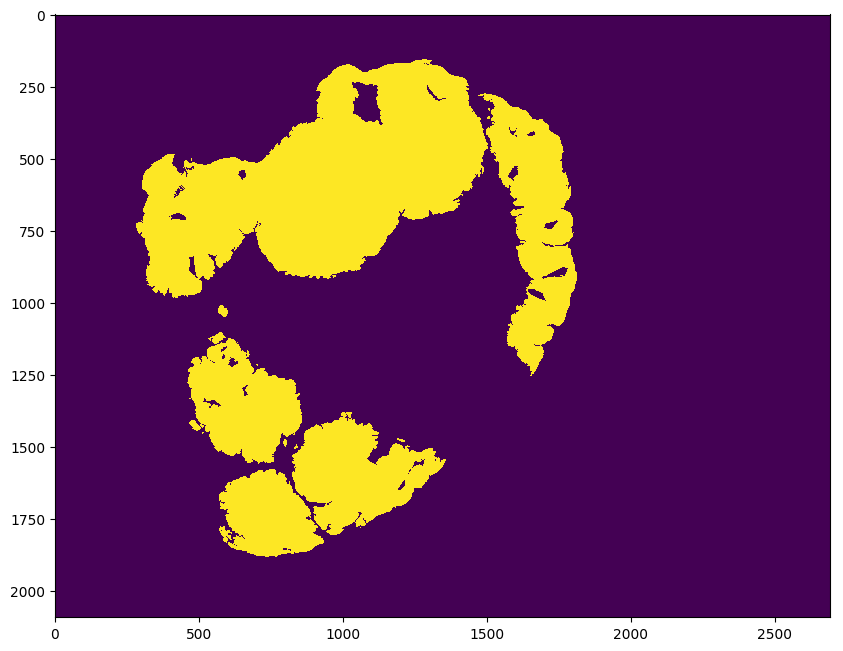

In [0]:
# Example: read the entire mask at the same zoom level
'''
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])
'''

mask_image = read_slide(tumor_mask, 
                         x=tlx*factor, 
                         y=tly*factor, 
                         level=5, 
                         width=new_w, 
                         height=new_h)
# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

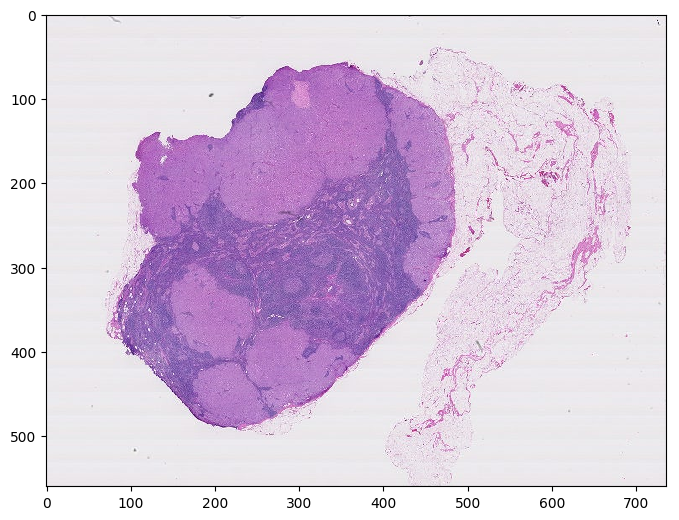

In [0]:
slide_crop = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_crop)
#plt.imsave(drive_path + 'heat/' + 'heat_patch.jpg', slide_crop)

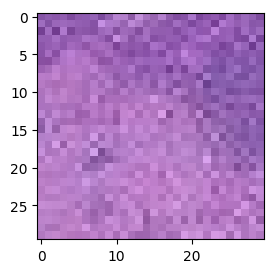

In [0]:
# level 7 patch region
factor = 128
slide_crop = read_slide(slide, 
                         x=170*factor, 
                         y=290*factor, 
                         level=7, 
                         width=30, 
                         height=30)
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(slide_crop)
plt.imsave(drive_path + 'heat/' + 'patch.jpg', slide_crop)

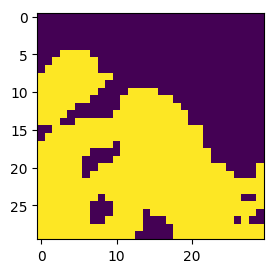

In [0]:
# Example: read the entire mask at the same zoom level
'''
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])
'''

# level 7 mask region
mask_image = read_slide(tumor_mask, 
                         x=170*factor, 
                         y=290*factor, 
                         level=7, 
                         width=30, 
                         height=30)
# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(mask_image)
plt.imsave(drive_path + 'heat/' + 'mask.jpg', mask_image)

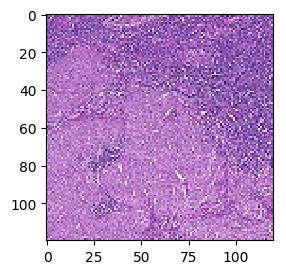

In [0]:
# level 7 patch region
factor = 32
slide_crop = read_slide(slide, 
                         x=170*4*factor, 
                         y=290*4*factor, 
                         level=5, 
                         width=120, 
                         height=120)
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(slide_crop)
#plt.imsave(drive_path + 'heat/' + 'heat_patch.jpg', slide_crop)

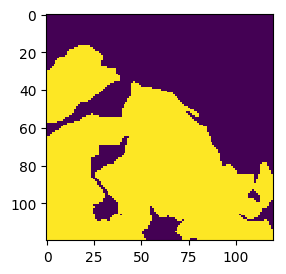

In [0]:
# level 5 corresponding region
factor = 32
mask_image = read_slide(tumor_mask, 
                         x=170*4*factor, 
                         y=290*4*factor, 
                         level=5, 
                         width=120, 
                         height=120)
# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(mask_image)
#plt.imsave(drive_path + 'heat/' + 'heat_mask.jpg', mask_image)

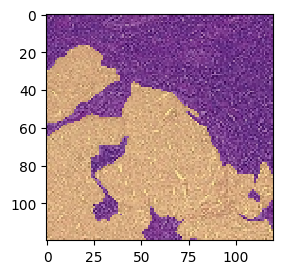

In [0]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(slide_crop)
plt.imshow(mask_image, cmap='viridis', alpha=0.44)

2118713 tissue_pixels pixels (42.2 percent of the image)


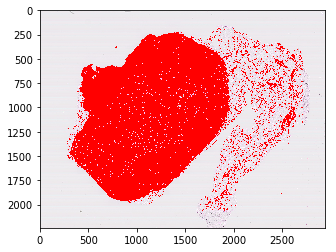

In [0]:
# Ignore non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8, margin=0.08):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    # exclude margin
    x_margin = image.shape[0]*margin
    y_margin = image.shape[1]*margin
    pixels = zip(indices[0], indices[1])
    pix = [i for i in pixels if (i[0]>x_margin and i[0]<image.shape[0]-x_margin and i[1]>y_margin and i[1]<image.shape[1]-y_margin)]
    return pix
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

## Training data

In [0]:
# Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def extract_train(level=5, size=299):
  slides = ['002', '005', '012', '016', '019','031', '035', '059', '075', '078', '081', '084', '091', '094', '096', '101', '110'] # all usable ones
  slides = ['078', '084', '091', '094', '096', '101', '110'] # all good ones, rm 081 # rm 001, 023, 57
  slides = ['078', '084', '091', '094', '096', '101'] # all for training, use 110 for test
  
  for s in slides:
    print("====== Starting slide %s =======" %s)
    # my GCS
    slide_path = 'tumor_' + s + '.tif'
    tumor_mask_path = 'tumor_' + s +'_mask.tif'

    slide_url = 'https://storage.googleapis.com/adl-project/slides/%s' % slide_path
    mask_url = 'https://storage.googleapis.com/adl-project/slides/%s' % tumor_mask_path

    # slide id
    sid = int(s)

    # Download the whole slide image
    if not os.path.exists(slide_path):
      !curl -O $slide_url

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):
      !curl -O $mask_url

    # Read the slide
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[0][0], 
                                                            slide.level_dimensions[0][1]))
    # Read tumor mask
    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    '''
    print("Slide includes %d levels" % len(slide.level_dimensions))
    for i in range(len(tumor_mask.level_dimensions)):
        print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                                 slide.level_dimensions[i], 
                                                                 slide.level_downsamples[i]))
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

    # Verify downsampling works as expected
    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    '''
    
    #sample_num = int(slide.level_dimensions[level][0] * slide.level_dimensions[level][1] / size / size)
    sample_num = 60 # 60 * 2 = 120 samples per slide
    factor = int(slide.level_downsamples[level])
    print("Level %d, dimensions: %s downsample factor %d" % (level, 
                                                                 slide.level_dimensions[level], 
                                                                 slide.level_downsamples[level]))
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=level, 
                             width=slide.level_dimensions[level][0], 
                             height=slide.level_dimensions[level][1])
    # find tissue pixels for this slide
    margin = 0.1
    tissue_pixels = find_tissue_pixels(slide_image, margin=margin)
    print("Tissue pixel number: %d" %len(tissue_pixels))
    # exclude margin regions
    print("slide image size %d,%d" %(slide_image.shape[1], slide_image.shape[0]))
    tissue_pixels = [i for i in tissue_pixels if (i[0]>size and i[0]<slide_image.shape[1]-size and i[1]>size and i[1]<slide_image.shape[0]-size)]
    
    # reset iid, pos, neg for this slide
    iid = 0 # sample id
    pos = 0
    neg = 0
    while (pos < sample_num or neg < sample_num): # force class balance
      
      # randomly choose sample pixel
      p_idx = np.random.choice(len(tissue_pixels), 1)[0]
      p = tissue_pixels[p_idx]

      # read image grid
      image = read_slide(slide, 
                             x=p[0] * factor - size//2, 
                             y=p[1] * factor - size//2, 
                             level=level, 
                             width=size, 
                             height=size)
      # read mask grid
      mask = read_slide(tumor_mask, 
                             x=p[0] * factor - size//2, 
                             y=p[1] * factor - size//2, 
                             level=level, 
                             width=size, 
                             height=size)[:,:,0]
      # determine sample class, write to Google Drive
      is_positive = np.sum(mask)
      if iid < sample_num * 0.8:
        d = 'l' + str(level) + '_train/'
      else:
        d = 'l' + str(level) + '_val/'
      if is_positive and pos < sample_num:
        print("save %d_%d: class 1" %(sid,iid))
        plt.imsave(drive_path + d + '1/' + str(sid) + '_' + str(iid) + '.png', image)
        pos += 1
      else:
        if neg < sample_num:
          print("save %d_%d: class 0" %(sid,iid))
          plt.imsave(drive_path + d + '0/' + str(sid) + '_' + str(iid) + '.png', image)
          neg += 1
      iid += 1
    print("======= Finish slide %s =======" %s)
    #print("sample pixel %d, %d" %p)
    #plt.figure(figsize=(10,10), dpi=100)
    #plt.imshow(image)


# Training data

Level 5, dimensions: (2944, 2240) downsample factor 32
Tissue pixel number: 2108653
slide image size 2944,2240
save 101_0: class 1
save 101_1: class 1
save 101_2: class 0
save 101_3: class 1
save 101_4: class 0
save 101_5: class 0
save 101_6: class 0
save 101_7: class 0
save 101_8: class 1
save 101_9: class 1
save 101_10: class 0
save 101_11: class 0
save 101_12: class 0
save 101_13: class 0
save 101_14: class 1
save 101_15: class 0
save 101_16: class 0
save 101_17: class 0
save 101_18: class 0
save 101_19: class 0
save 101_20: class 0
save 101_21: class 0
save 101_22: class 0
save 101_23: class 0
save 101_24: class 0
save 101_25: class 0
save 101_26: class 1
save 101_27: class 0
save 101_28: class 0
save 101_29: class 1
save 101_30: class 0
save 101_31: class 1
save 101_32: class 0
save 101_33: class 1
save 101_34: class 0
save 101_35: class 0
save 101_36: class 0
save 101_37: class 1
save 101_38: class 1
save 101_39: class 0
save 101_40: class 0
save 101_41: class 0
save 101_42: clas

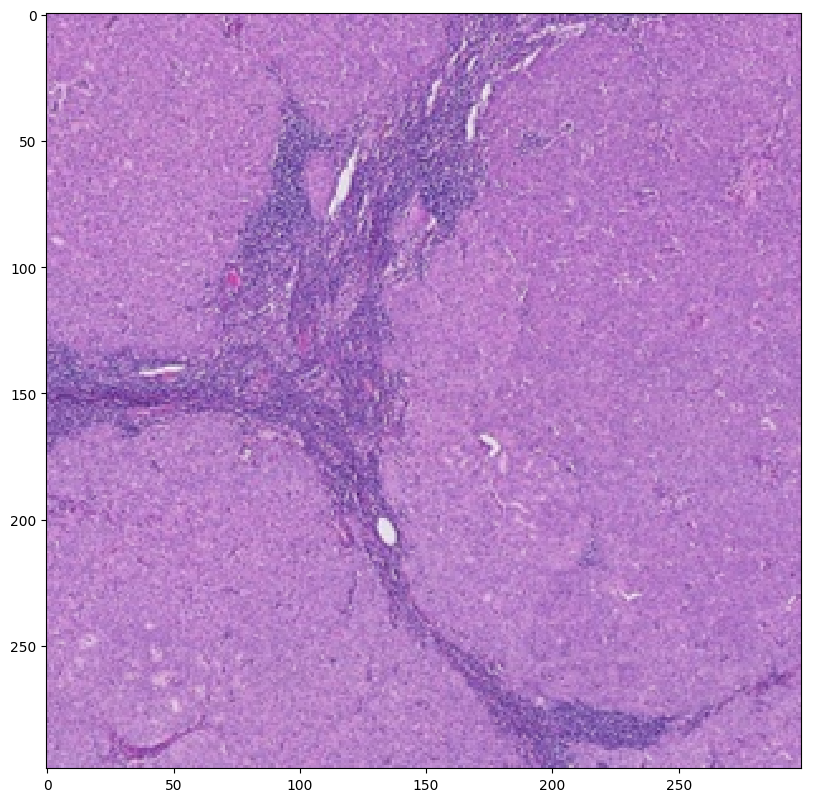

In [0]:
slides = ['078', '084', '091', '094', '096', '101']

s = slides[5]

sid = int(s)

level = 5
size = 299 # 299 x 299 grid
#sample_num = int(slide.level_dimensions[level][0] * slide.level_dimensions[level][1] / size / size * 1.6)
sample_num = 60 # 60 * 2 = 120 samples per slides
factor = int(slide.level_downsamples[level])
print("Level %d, dimensions: %s downsample factor %d" % (level, 
                                                             slide.level_dimensions[level], 
                                                             slide.level_downsamples[level]))
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
# find tissue pixels for this slide
margin = 0.1
tissue_pixels = find_tissue_pixels(slide_image, margin=margin)
print("Tissue pixel number: %d" %len(tissue_pixels))
# exclude margin regions
print("slide image size %d,%d" %(slide_image.shape[1],slide_image.shape[0]))
tissue_pixels = [i for i in tissue_pixels if (i[0]>size and i[0]<slide_image.shape[1]-size and i[1]>size and i[1]<slide_image.shape[0]-size)]


iid = 0 # sample id
pos = 0 # pos count
neg = 0 # neg count
while (pos < sample_num or neg < sample_num):
  idx = np.random.choice(len(tissue_pixels), 1)[0]
  # select sample pixel
  p = tissue_pixels[idx]
  # read image grid
  image = read_slide(slide, 
                         x=p[0] * factor - size//2, 
                         y=p[1] * factor - size//2, 
                         level=level, 
                         width=size, 
                         height=size)
  # read mask grid
  mask = read_slide(tumor_mask, 
                         x=p[0] * factor - size//2, 
                         y=p[1] * factor - size//2, 
                         level=level, 
                         width=size, 
                         height=size)[:,:,0]
  # determine sample class, write to Google Drive
  roi = [mask[size//2][size//2], mask[size//2+1][size//2], mask[size//2][size//2+1], mask[size//2+1][size//2+1]]
  is_positive = np.sum(roi)
  #print("Roi sum %d" %is_positive)
  if is_positive and pos < sample_num:
    if pos < sample_num * 0.8:
      d = 'c5_train/'
    else:
      d = 'c5_val/'
    print("save %d_%d: class 1" %(sid,iid))
    plt.imsave(drive_path + d + '1/' + str(sid) + '_' + str(iid) + '.jpg', image)
    pos += 1
    iid += 1
  elif (not is_positive) and neg < sample_num:
    if neg < sample_num * 0.8:
      d = 'c5_train/'
    else:
      d = 'c5_val/'
    print("save %d_%d: class 0" %(sid,iid))
    plt.imsave(drive_path + d + '0/' + str(sid) + '_' + str(iid) + '.jpg', image)
    neg += 1
    iid += 1
print("sample pixel %d, %d" %p)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(image)

## Test Data

In [0]:
s = '110'

sid = int(s)

level = 5
size = 299 # 299 x 299 grid
factor = int(slide.level_downsamples[level])
print("Level %d, dimensions: %s downsample factor %d" % (level, 
                                                             slide.level_dimensions[level], 
                                                             slide.level_downsamples[level]))


w_num = slide.level_dimensions[5][0]//size # w_num
h_num = slide.level_dimensions[5][1]//size # h_num

new_w = size*w_num
new_h = size*h_num

assert new_w % 299 == 0
assert new_h % 299 == 0

tlx = (slide.level_dimensions[5][0] - size*w_num)//2
tly = (slide.level_dimensions[5][1] - size*h_num)//2
print(type(tlx))
print(tly)

slide_image = read_slide(slide, 
                         x=tlx*factor, 
                         y=tly*factor, 
                         level=5, 
                         width=new_w, 
                         height=new_h)
coor = []
for i in range(w_num):
  for j in range(h_num):
    x = tlx + size * i
    y = tly + size * j
    coor.append((x,y))
print(coor)

# Sliding window


iid = 0 # sample id
pos = 0 # pos count
neg = 0 # neg count
for c in coor:
  # read image grid
  image = read_slide(slide, 
                         x=c[0] * factor, 
                         y=c[1] * factor, 
                         level=level, 
                         width=size, 
                         height=size)
  # read mask grid
  mask = read_slide(tumor_mask, 
                         x=c[0] * factor, 
                         y=c[1] * factor, 
                         level=level, 
                         width=size, 
                         height=size)[:,:,0]
  # test dir
  d = 'c' + str(level) + '_test/'
  
  # determine sample class, write to Google Drive
  roi = [mask[size//2][size//2], mask[size//2+1][size//2], mask[size//2][size//2+1], mask[size//2+1][size//2+1]]
  is_positive = np.sum(roi)
  if is_positive:
    print("save %d_%d: class 1" %(sid,iid))
    plt.imsave(drive_path + d + '1/' + str(sid) + '_' + str(iid) + '.jpg', image)
    pos += 1
  else:
    print("save %d_%d: class 0" %(sid,iid))
    plt.imsave(drive_path + d + '0/' + str(sid) + '_' + str(iid) + '.jpg', image)
    neg += 1
  iid += 1

Level 5, dimensions: (2944, 2240) downsample factor 32
<type 'int'>
73
[(126, 73), (126, 372), (126, 671), (126, 970), (126, 1269), (126, 1568), (126, 1867), (425, 73), (425, 372), (425, 671), (425, 970), (425, 1269), (425, 1568), (425, 1867), (724, 73), (724, 372), (724, 671), (724, 970), (724, 1269), (724, 1568), (724, 1867), (1023, 73), (1023, 372), (1023, 671), (1023, 970), (1023, 1269), (1023, 1568), (1023, 1867), (1322, 73), (1322, 372), (1322, 671), (1322, 970), (1322, 1269), (1322, 1568), (1322, 1867), (1621, 73), (1621, 372), (1621, 671), (1621, 970), (1621, 1269), (1621, 1568), (1621, 1867), (1920, 73), (1920, 372), (1920, 671), (1920, 970), (1920, 1269), (1920, 1568), (1920, 1867), (2219, 73), (2219, 372), (2219, 671), (2219, 970), (2219, 1269), (2219, 1568), (2219, 1867), (2518, 73), (2518, 372), (2518, 671), (2518, 970), (2518, 1269), (2518, 1568), (2518, 1867)]
save 110_0: class 0
save 110_1: class 0
save 110_2: class 0
save 110_3: class 0
save 110_4: class 0
save 110_5: 

## Heatmap Input Data

In [0]:
s = '110'

sid = int(s)

level = 5
size = 299 # 299 x 299 grid
factor = int(slide.level_downsamples[level])
print("Level %d, dimensions: %s downsample factor %d" % (level, 
                                                             slide.level_dimensions[level], 
                                                             slide.level_downsamples[level]))

# a 30 x 30 patch with top left corner being 170, 290 in lv7
# corresponds to 120 x 120 patch in lv5
# extract 900 images out of lv5

# level 7 patch region
factor = 32
slide_crop = read_slide(slide, 
                         x=170*4*factor, 
                         y=290*4*factor, 
                         level=5, 
                         width=120, 
                         height=120)

slide_crop = read_slide(tumor_mask, 
                         x=170*4*factor, 
                         y=290*4*factor, 
                         level=5, 
                         width=120, 
                         height=120)

centers = []
scale = 4 # scale of lv5 / lv7
for i in range(30):
  for j in range(30):
    x = 170 * scale + j * scale
    y = 290 * scale + i * scale
    centers.append((x,y))
    
print(centers)
# Sliding window


iid = 0 # sample id
pos = 0 # pos count
neg = 0 # neg count
for c in centers:
  # read image grid
  image = read_slide(slide, 
                         x=c[0] * factor - size//2, 
                         y=c[1] * factor - size//2, 
                         level=level, 
                         width=size, 
                         height=size)
  
  
  # read mask grid
  mask = read_slide(tumor_mask, 
                         x=c[0] * factor - size//2, 
                         y=c[1] * factor - size//2, 
                         level=level, 
                         width=size, 
                         height=size)[:,:,0]
  # test dir
  d = 'c' + str(level) + '_heatmap/'
  
  # determine sample class, write to Google Drive
  roi = [mask[size//2][size//2], mask[size//2+1][size//2], mask[size//2][size//2+1], mask[size//2+1][size//2+1]]
  is_positive = np.sum(roi)
  if is_positive:
    print("save %d_%d, location %d,%d: class 1" %(sid,iid, c[0],c[1]))
    plt.imsave(drive_path + d + '1/' + str(sid) + '_' + str(iid) + '.jpg', image)
    pos += 1
  else:
    print("save %d_%d: class 0" %(sid,iid))
    plt.imsave(drive_path + d + '0/' + str(sid) + '_' + str(iid) + '.jpg', image)
    neg += 1
  iid += 1

Level 5, dimensions: (2944, 2240) downsample factor 32
[(680, 1160), (684, 1160), (688, 1160), (692, 1160), (696, 1160), (700, 1160), (704, 1160), (708, 1160), (712, 1160), (716, 1160), (720, 1160), (724, 1160), (728, 1160), (732, 1160), (736, 1160), (740, 1160), (744, 1160), (748, 1160), (752, 1160), (756, 1160), (760, 1160), (764, 1160), (768, 1160), (772, 1160), (776, 1160), (780, 1160), (784, 1160), (788, 1160), (792, 1160), (796, 1160), (680, 1164), (684, 1164), (688, 1164), (692, 1164), (696, 1164), (700, 1164), (704, 1164), (708, 1164), (712, 1164), (716, 1164), (720, 1164), (724, 1164), (728, 1164), (732, 1164), (736, 1164), (740, 1164), (744, 1164), (748, 1164), (752, 1164), (756, 1164), (760, 1164), (764, 1164), (768, 1164), (772, 1164), (776, 1164), (780, 1164), (784, 1164), (788, 1164), (792, 1164), (796, 1164), (680, 1168), (684, 1168), (688, 1168), (692, 1168), (696, 1168), (700, 1168), (704, 1168), (708, 1168), (712, 1168), (716, 1168), (720, 1168), (724, 1168), (728, 11